In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
x_train = train.drop(["id","loss"],axis = 1)
y = train["loss"]
x_test = test.drop(["id"],axis = 1)

## Feature selection

## For continuous values

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
cont_features = [cf for cf in x_train.columns if "cont" in cf]
x_tr = x_train[cont_features]

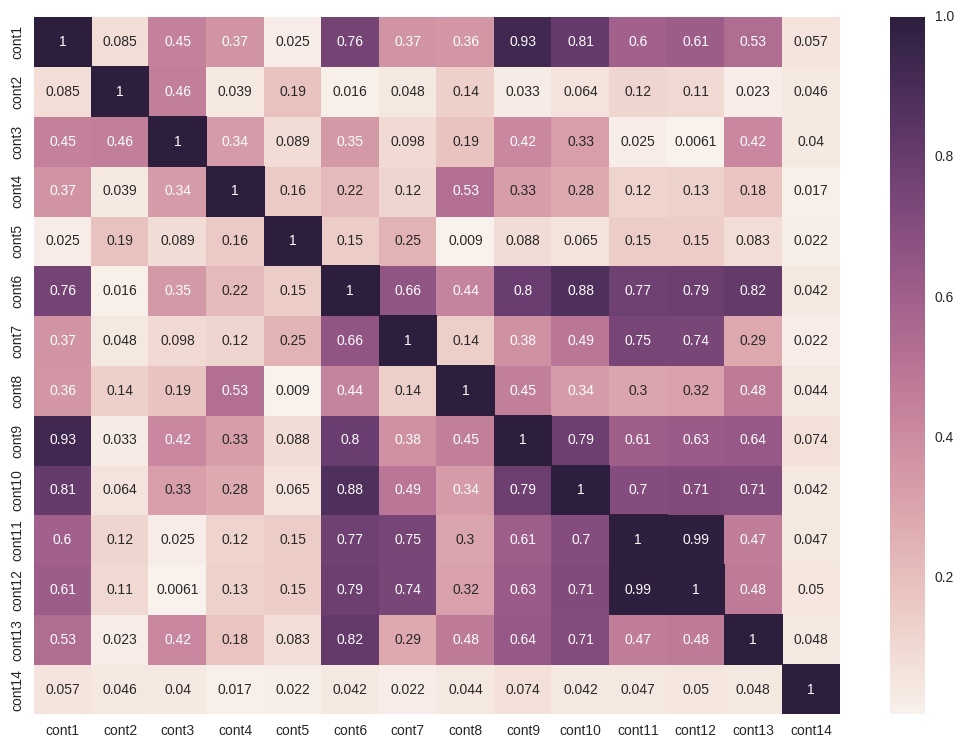

In [7]:
correlationMatrix = x_tr.corr().abs()

plt.subplots(figsize=(13, 9))
sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False)
plt.show()


In [8]:
unstacked_cm = correlationMatrix.unstack()
sorted_corr = unstacked_cm.order(kind="quicksort")
print(sorted_corr[sorted_corr > 0.60])

cont9   cont11    0.608000
cont11  cont9     0.608000
cont12  cont1     0.614225
cont1   cont12    0.614225
cont9   cont12    0.626656
cont12  cont9     0.626656
cont9   cont13    0.642028
cont13  cont9     0.642028
cont7   cont6     0.658918
cont6   cont7     0.658918
cont11  cont10    0.702896
cont10  cont11    0.702896
        cont13    0.707876
cont13  cont10    0.707876
cont12  cont10    0.713812
cont10  cont12    0.713812
cont12  cont7     0.742712
cont7   cont12    0.742712
        cont11    0.747108
cont11  cont7     0.747108
cont6   cont1     0.758315
cont1   cont6     0.758315
cont11  cont6     0.773745
cont6   cont11    0.773745
cont12  cont6     0.785144
cont6   cont12    0.785144
cont10  cont9     0.785697
cont9   cont10    0.785697
cont6   cont9     0.797544
cont9   cont6     0.797544
cont10  cont1     0.808551
cont1   cont10    0.808551
cont13  cont6     0.815091
cont6   cont13    0.815091
        cont10    0.883351
cont10  cont6     0.883351
cont9   cont1     0.929912
c

/home/achal/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


In [9]:
remove_cont_features = ["cont6","cont10","cont12","cont9","cont11"]

for rf in remove_cont_features:
    cont_features.remove(rf)

In [10]:
remove_cont_features

['cont6', 'cont10', 'cont12', 'cont9', 'cont11']

## Find correlation between Categorical features

In [11]:
from sklearn.preprocessing import LabelEncoder
def onehotencoding(data,catFeaturesList_,le,maxCatValues):
    cats = []
    for catFeature in catFeaturesList_:
        labels = data[catFeature].unique()
        if(len(labels) < maxCatValues and len(labels) > 2):
            features = pd.get_dummies(data[catFeature])
            #print(features.columns)
            features.columns = catFeature + " = " + features.columns

            #print(catFeature)
            data = data.drop(catFeature,axis=1)
            data = pd.concat([data,features.astype(int)],axis=1)
        else:
            le.fit(labels)
            data[catFeature] = le.transform(data[catFeature])
    return(data)

In [12]:
catFeatureslist = [cf for cf in train.columns if "cat" in cf]

In [13]:
tr_data_norm = onehotencoding(x_train,catFeatureslist,LabelEncoder(),maxCatValues=2)
te_data_norm = onehotencoding(x_test,catFeatureslist,LabelEncoder(),maxCatValues=2)

In [14]:
tr_data_norm.columns

Index(['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9',
       'cat10',
       ...
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11',
       'cont12', 'cont13', 'cont14'],
      dtype='object', length=130)

In [15]:
tr_data_norm.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


In [16]:
cat_one_code_list =  [cf for cf in tr_data_norm.columns if ("cat" in cf) & (len(tr_data_norm[cf].unique()) == 2)]

In [17]:
len(cat_one_code_list)

72

In [18]:
import itertools
from itertools import compress

In [19]:
from scipy.stats import chi2_contingency

def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]
    #print(result)

    return chi2_contingency(result)

def chi_square_df(data,features):
    catCorrMat = pd.DataFrame(columns=["cat1","cat2","p"])
    i = 0
    for cat1,cat2 in itertools.combinations(features,2):
        _,p,_,_ = chi_square_of_df_cols(data,cat1,cat2)

        catCorrMat.loc[i] = [cat1,cat2,p]
        i = i +1
    
    return catCorrMat

## Binary categorical features

In [20]:
len(cat_one_code_list)

72

In [21]:
len(list(itertools.combinations(cat_one_code_list,2)))

2556

In [22]:
catCorrMat = pd.DataFrame(columns=["cat1","cat2","p"])
i = 0

for cat1,cat2 in itertools.combinations(cat_one_code_list,2):
    _,p,_,_ = chi_square_of_df_cols(tr_data_norm,cat1,cat2)
    print(i)
    catCorrMat.loc[i] = [cat1,cat2,p]
    i = i +1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
catSorted = catCorrMat.sort("p",ascending=False)

/home/achal/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [72]:
catSorted 

,cat1,cat2,p
953,cat15,cat66,0.996654
1311,cat22,cat53,0.995860
1680,cat30,cat58,0.994096
1951,cat37,cat63,0.993411
1151,cat19,cat46,0.991132
1766,cat32,cat63,0.990993
1673,cat30,cat51,0.989962
451,cat7,cat48,0.989355
1103,cat18,cat51,0.988793
1275,cat21,cat67,0.988552


In [83]:
catSorted_f = catSorted[catSorted.p > 0.99]

In [86]:
catSorted_f

,cat1,cat2,p
953,cat15,cat66,0.996654
1311,cat22,cat53,0.995860
1680,cat30,cat58,0.994096
1951,cat37,cat63,0.993411
1151,cat19,cat46,0.991132
1766,cat32,cat63,0.990993


In [71]:
remove_corrcat = []
for cat in catSorted_f.cat1.unique():
    if len(catSorted_f[(catSorted_f.cat1 == cat) | (catSorted_f.cat2 == cat)]) > 4:
        catSorted_f = catSorted_f[(catSorted_f.cat1 != cat) & (catSorted_f.cat2 != cat)]
    print(cat)
    remove_corrcat.append(cat)

cat15
cat22
cat30
cat37
cat19
cat32


In [24]:
catCorrMat.to_csv("cat_corr_matrix.csv")

In [69]:
remove_corrcat

['cat15',
 'cat22',
 'cat30',
 'cat37',
 'cat19',
 'cat32',
 'cat7',
 'cat18',
 'cat21',
 'cat20',
 'cat26',
 'cat38',
 'cat43',
 'cat8',
 'cat5',
 'cat11',
 'cat1',
 'cat35',
 'cat40',
 'cat54',
 'cat23',
 'cat25',
 'cat45',
 'cat24',
 'cat55',
 'cat39',
 'cat36',
 'cat50',
 'cat47']